# Détection d'e-mails de phishing et prise de décision

Les données utilisées dans ce projet proviennent de l'URL suivant : https://www.kaggle.com/datasets/subhajournal/phishingemails. Elles concernent des corps de mails étiquettés comme "safe" ou "phishing".

In [1]:
#Zones d'importation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

In [2]:
#Chargement du dataset

df = pd.read_csv("Phishing_Email.csv")

#Nettoyage des valeurs Nan

df.dropna(inplace=True)

In [3]:
#Visualisation du contenu

df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [4]:
#Suppression de la première colonne

df = df.iloc[:, 1:]
df.head()

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


Nous choisissons la vectorisation TF-IDF, afin de transformer le texte brut des e-mails en vecteurs à valeurs pondérées qui mettent en avant les termes les plus importants d’un mail par rapport à l’ensemble du corps de texte. Elle va alors nous permettre de mieux capturer les mots différenciant les mails de phishing et légitimes. Nous choisissons un nombre maximal de mots de 5000 sur près de 18000 corps de mail afin de s'assurer de leur significativité tout en minimisant l'overfitting du modèle. Nous fixons ce paramètre que nous pourrions chercher à optimiser moyennant un temps de calcul plus important.

In [5]:
#Initialisation du vectoriseur TF-IDF

vectoriseur = TfidfVectorizer(stop_words='english', max_features=5000)

#Transformation du texte en vecteurs TF-IDF

X = vectoriseur.fit_transform(df['Email Text'])

#Initialisation de la variable cible (type de mail)

y = df['Email Type']
le = LabelEncoder()
y_enc = le.fit_transform(y)

In [6]:
#Vérification de l'équilibre des classes

y.value_counts()

Email Type
Safe Email        11322
Phishing Email     7312
Name: count, dtype: int64

Notre dataset présente un déséquilibre modéré entre les types de mail (60%/40%) : ce léger niveau de déséquilibre reste acceptable pour une classification binaire comme la nôtre. Nous allons le prendre en compte dans la séparation de notre dataset :

In [7]:
#Séparation en train/test sets (80%/20%)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=1, stratify=y_enc)

Dans ce projet, nos évaluerons les modèles de classification suivants :

- Logistic Regression

- Random Forest 

- Support Vector Machine 

In [8]:
#Dictionnaire des modèles avec leurs grilles de paramètres à optimiser

models_params = {
    
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=750),
        "params": [
            {
                'C': np.logspace(-3, 3, 7),
                'penalty': ['l1','l2'],
                'solver': ['liblinear', 'saga']},
            {
                'C': np.logspace(-3, 3, 7),
                'penalty': ['elasticnet'],
                'solver': ['saga'],
                'l1_ratio': [0.25, 0.5, 0.75]}]},
    
    "SVC": {
        "model": SVC(),
        "params": {
            'C': np.logspace(-1, 2, 4),
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}},
    
    "RandomForestClassifier": {
        "model": RandomForestClassifier(random_state=1),
        "params": {
            'n_estimators': [250, 500],
            'max_depth': [None, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 3],
            'max_features': ['sqrt', 'log2'],
            'bootstrap': [True, False]}}}

Afin d'optimiser la performance des modèles choisis, nous allons utiliser le GridSearchCV pour déterminer les hyperparamètres qui maximisent leurs performances. 

In [9]:
#Dictionnaire pour stocker les modèles optimisés et les scores

meilleurs_modeles = {}
score = {}
params_optimaux = {}

#Boucle sur chaque modèle

for nom, modele in models_params.items():

    #GridSearch pour hyperparamètres
    grid = GridSearchCV(modele["model"], modele["params"], cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    #Paramètres optimaux
    params_optimaux[nom] = grid.best_params_
    
    #Meilleur modèle
    best_model = grid.best_estimator_
    meilleurs_modeles[nom] = best_model
    
    #Évaluation via cross_val_score
    scores = cross_val_score(best_model, X_train, y_train, cv=3, scoring='accuracy')
    score[nom] = scores

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

Les warnings correspondent aux modèles testés dont le nombre d'itérations dépasse le seuil fixé et donc ne convergent pas.

In [10]:
for nom in meilleurs_modeles:
    print(f"Paramètres optimaux pour {nom} : {params_optimaux[nom]}")
    print(f"Précision moyenne : {score[nom].mean():.4f} ± {score[nom].std():.4f}\n")

Paramètres optimaux pour LogisticRegression : {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}
Précision moyenne : 0.9687 ± 0.0016

Paramètres optimaux pour SVC : {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
Précision moyenne : 0.9695 ± 0.0016

Paramètres optimaux pour RandomForestClassifier : {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Précision moyenne : 0.9673 ± 0.0021



Nos modèles semblent tous globalement très bons pour prédire nos classes de mails. En revanche, une erreur de type faux positif n'a pas le même coût qu'une erreur faux négatif en fonction de l'utilisation ou du professionnel qui l'utilise. Nous allons donc analyser ces types d'erreurs à travers les matrices de confusion.

In [11]:
#Dictionnaire pour stocker les matrices de confusion

matrices_confusion = {}

#Boucle sur chaque modèle

for nom, modele in meilleurs_modeles.items():
    
    y_pred = modele.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    matrices_confusion[nom] = cm
    
    print(f"Matrice de confusion pour {nom} :\n{cm}")

Matrice de confusion pour LogisticRegression :
[[1427   35]
 [  71 2194]]
Matrice de confusion pour SVC :
[[1426   36]
 [  64 2201]]
Matrice de confusion pour RandomForestClassifier :
[[1414   48]
 [  59 2206]]


Globalement, à contraintes équivalentes, un modèle qui parvient à minimiser à la fois les faux positifs et les faux négatifs sera naturellement privilégié. En revanche, lorsque certains modèles excellent dans la réduction d’un type d’erreur au détriment de l’autre, le choix du modèle dépendra alors des préférences du décideur, et notamment de son niveau d’aversion vis-à-vis de chaque type d’erreur.

In [12]:
#Initilisation des valeurs minimales de faux positifs/négatifs et des matrices correspondantes

minfp, matfp = np.inf, np.zeros((2,2))
minfn, matfn = np.inf, np.zeros((2,2))

#Boucle sur chaque matrice

for c in matrices_confusion.values():
    if c[0][1] < minfp :
        minfp = c[0][1]
        matfp = c
    if c[1][0] < minfn :
        minfn = c[1][0]
        matfn = c
        
#Une même matrice possède les valeurs minimales de faux positifs et négatifs

if np.array_equal(matfp, matfn) :
    for modele, cm in matrices_confusion.items():
        if np.array_equal(cm, matfp):
            mod = modele
    print(f'Le modèle {mod} est celui qui minimise les erreurs "faux positif" et "faux négatif", voici sa confusion matrix :')
    disp = ConfusionMatrixDisplay(confusion_matrix=matfn, display_labels=["Safe", "Phishing"])
    plt.figure(figsize=(6, 4))
    disp.plot(cmap="Greens", values_format='d')
    plt.title(f"Matrice de confusion - {mod}")
    plt.grid(False)
    plt.show()

#Ce n'est pas le cas

else:
    print("Aucun modèle ne minimise les deux types d'erreur, un arbitrage sur l'importance donnée à chaque type d'erreur s'impose.")

Aucun modèle ne minimise les deux types d'erreur, un arbitrage sur l'importance donnée à chaque type d'erreur s'impose.


Aucun des modèles ne parvient à minimiser simultanément les deux types d’erreurs, chaque modèle présente donc un compromis différent.
Pour guider la prise de décision dans ce contexte, nous introduisons une fonction de coût qui pondère l’importance relative des faux négatifs et des faux positifs. Ce critère, paramétré par un poids $p \in [0, 1]$, permet de sélectionner le modèle le plus adapté aux priorités opérationnelles du décideur.

Par exemple, un administrateur système qui se soucie de la sécurité pourrait préférer minimiser les faux négatifs ($p>0.5$), c’est-à-dire éviter de laisser passer un email de phishing, quitte à classer à tort quelques emails légitimes comme suspects. À l’inverse, un service client pourrait chercher à minimiser les faux positifs ($p<0.5$) afin d’éviter de bloquer inutilement des communications valides avec les utilisateurs. Enfin, un décideur neutre ou sans préférence pourrait simplement vouloir minimiser le nombre total d’erreurs ($p=0.5$), en équilibrant les deux types d’erreurs de manière équitable.

Chaque décideur cherchera alors à minimser sa fonction de coût relativement au nombres d'erreurs selon leur type (FP : Faux Positifs, pondéré par $1-p$ et FN : Faux Négatifs, pondéré par $p$). Dans le cas d'une fonction de préférence linéaire, on peut ainsi définir $ f_p(FN,FP) = p \times FN + (1-p) \times FP $. Cette fonction est ensuite évaluée pour chaque modèle afin d’identifier celui qui minimise le coût global selon les préférences du décideur.

In [13]:
def fc(matrices_confusion, p):
    if 0 <= p <= 1: 
        meilleur_modele = None
        meilleure_cm = None
        score_min = np.inf

        for nom, cm in matrices_confusion.items():
            fp = cm[0, 1]  #Faux positifs
            fn = cm[1, 0]  #Faux négatifs
            score = p * fn + (1 - p) * fp #Coût

            if score < score_min:
                score_min = score
                meilleur_modele = nom
                meilleure_cm = cm

        print(f"Meilleur modèle pour p={p}: {meilleur_modele}")
        disp = ConfusionMatrixDisplay(confusion_matrix=meilleure_cm, display_labels=["Safe", "Phishing"])
        plt.figure(figsize=(6, 4))
        disp.plot(cmap="Greens", values_format='d')
        plt.title(f"Matrice de confusion - {meilleur_modele}")
        plt.grid(False)
        plt.show()

        return meilleur_modele

Meilleur modèle pour p=0.95: RandomForestClassifier


<Figure size 600x400 with 0 Axes>

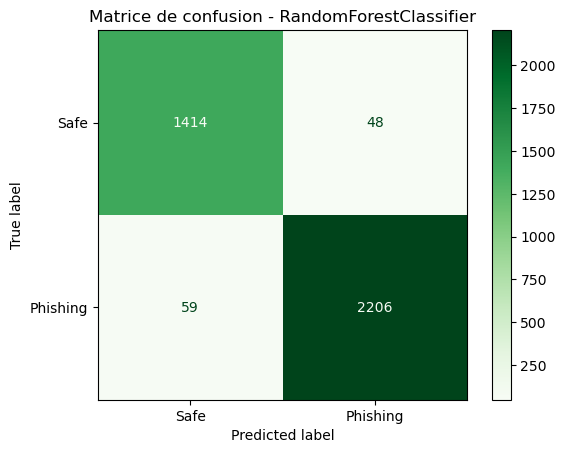

Meilleur modèle pour p=0.5: SVC


<Figure size 600x400 with 0 Axes>

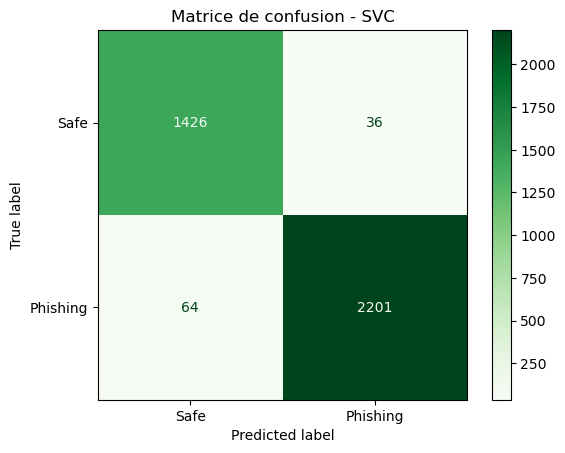

Meilleur modèle pour p=0.05: LogisticRegression


<Figure size 600x400 with 0 Axes>

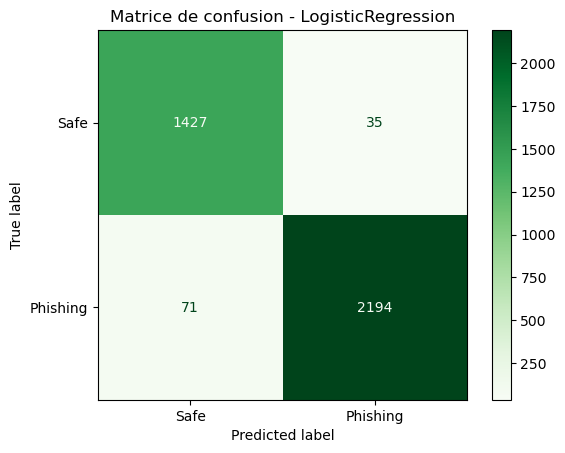

RandomForestClassifier SVC LogisticRegression


In [14]:
print(fc(matrices_confusion, p=0.95), fc(matrices_confusion, p=0.5), fc(matrices_confusion, p=0.05))

Nous remarquons que le modèle préféré par le décideur en fonction de son aversion aux deux types d'erreurs diffère beaucoup. Il pourrait alors être intéressant de tracer, pour chaque modèle et selon l'évolution du paramètre $p$, la courbe de la fonction de coût afin de faciliter la prise de décision.

Il est à noter qu'un décideur est indifférent entre utiliser un modèle 1 ou 2 si :

$$
FN_{\text{Modèle 1}} \times p + FP_{\text{Modèle 1}} \times (1-p) = FN_{\text{Modèle 2}} \times p + FP_{\text{Modèle 2}} \times (1-p)
$$

Cette équation est équivalente à :

$$
p = \frac{FP_{\text{M2}} - FP_{\text{M1}}}{(FN_{\text{M1}} - FP_{\text{M1}}) - (FN_{\text{M2}} - FP_{\text{M2}})}
$$

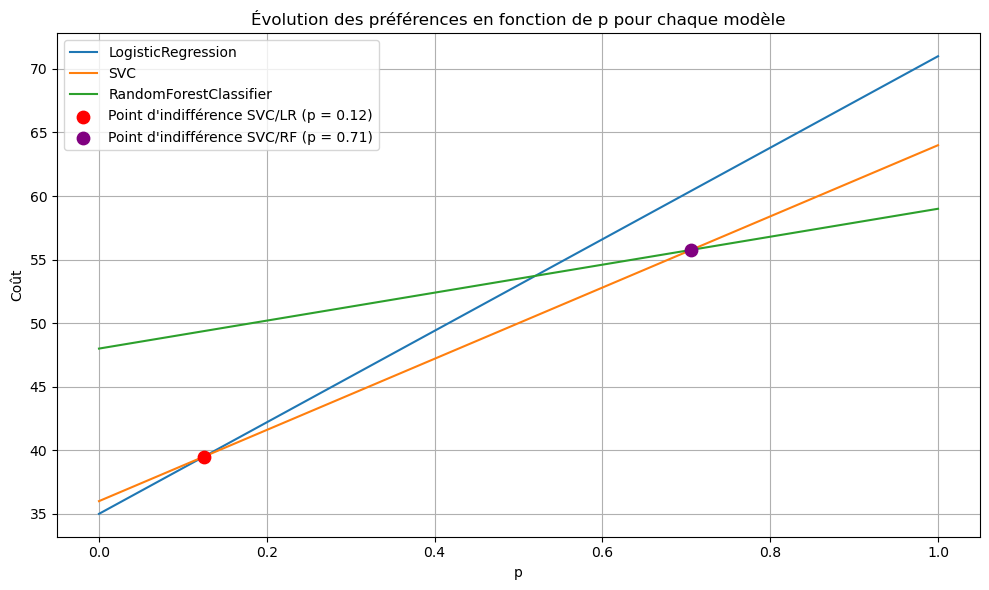

In [15]:
#Tracé des droites de préférence pour chaque modèle

val_p = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 6))

for nom, cm in matrices_confusion.items():
    fn = cm[1][0]
    fp = cm[0][1]
    scores = [p * fn + (1 - p) * fp for p in val_p]
    plt.plot(val_p, scores, label=nom)

#Premier point d'indifférence

fnsvc = matrices_confusion['SVC'][1][0]
fpsvc = matrices_confusion['SVC'][0][1]
fnlr = matrices_confusion['LogisticRegression'][1][0]
fplr = matrices_confusion['LogisticRegression'][0][1]
p = (fpsvc - fplr) / ( (fnlr - fplr) - (fnsvc - fpsvc) )
plt.scatter(p, p * fnsvc + (1 - p) * fpsvc, c='red', s=80, zorder=5, 
            label=f"Point d'indifférence SVC/LR (p = {round(p,2)})")

#Second point d'indifférence

fnrf = matrices_confusion['RandomForestClassifier'][1][0]
fprf = matrices_confusion['RandomForestClassifier'][0][1]
p = (fprf - fpsvc) / ( (fnsvc - fpsvc) - (fnrf - fprf) )
plt.scatter(p, p * fnsvc + (1 - p) * fpsvc, c='purple', s=80, zorder=5,
            label=f"Point d'indifférence SVC/RF (p = {round(p,2)})")

plt.xlabel("p")
plt.ylabel("Coût")
plt.title("Évolution du coût pour le décideur en fonction de p pour chaque modèle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Notre représentation graphique met en lumière que dans notre cas, un décideur très averse au risque de non détection ($ p > 0.71 $) va préférer utiliser le modèle de Random Forest qui minimise les erreurs de type faux négatifs. D'autres décideurs très averses au risque de fausse alerte ($ p < 0.12 $) préféreront le modèle de Régression Logistique. Enfin, des décideurs plus indifférents que ces derniers ($p \in [0.12, 0.71]$) préféreront utiliser un modèle de Support Vector Machine.

Pour un de nos modèles (par exemple celui de Régression Logistique), intéressons nous aux mots ayant la plus grande influence sur la prédiction de la nature d’un mail :

In [16]:
lr = meilleurs_modeles['LogisticRegression']

#Récupération des mots et coefficients associés

coefficients = lr.coef_[0]
mots = vectoriseur.get_feature_names_out()

#Mots associés au phishing (coefficients négatifs)

top_phishing = sorted(zip(coefficients, mots))[:10]

#Mots associés aux mails sûrs (coefficients positifs)

top_safe = sorted(zip(coefficients, mots), reverse=True)[:10]

print("Top 10 des mots associés au mails de phishing :")
print(pd.DataFrame(top_phishing, columns=["Coefficient", "Mot"]))

print("\nTop 10 des mots associés aux mails légitimes :")
print(pd.DataFrame(top_safe, columns=["Coefficient", "Mot"]))

Top 10 des mots associés au mails de phishing :
   Coefficient        Mot
0   -10.090262       2005
1    -8.492938  sightings
2    -7.007900     remove
3    -6.102538       2004
4    -5.827502      click
5    -5.627373    removed
6    -5.255633      money
7    -5.054120       free
8    -4.998672       life
9    -4.978196      email

Top 10 des mots associés aux mails légitimes :
   Coefficient         Mot
0    14.085926       enron
1    10.117766         url
2    10.110544       wrote
3     8.841197        2002
4     8.322817      thanks
5     7.670749    language
6     7.185944       vince
7     7.020811         edu
8     6.827990  university
9     6.788313    attached
